In [120]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC 
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df = pd.read_csv('coffe_sales.csv')
df.head()

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


## task here are as follow:
* Time series exploratory data analysis
* next day/week/month sales
* specific customer purchases 

## EDA

In [4]:
df.columns

Index(['date', 'datetime', 'cash_type', 'card', 'money', 'coffee_name'], dtype='object')

In [5]:
df.dtypes

date            object
datetime        object
cash_type       object
card            object
money          float64
coffee_name     object
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1313 non-null   object 
 1   datetime     1313 non-null   object 
 2   cash_type    1313 non-null   object 
 3   card         1224 non-null   object 
 4   money        1313 non-null   float64
 5   coffee_name  1313 non-null   object 
dtypes: float64(1), object(5)
memory usage: 61.7+ KB


In [7]:
## the card has missing values we gonna have to to deal with that
df.isnull().sum()

date            0
datetime        0
cash_type       0
card           89
money           0
coffee_name     0
dtype: int64

In [8]:
df.shape

(1313, 6)

In [9]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,1313,167,2024-07-30,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
datetime,1313,1313,2024-03-08 14:44:12.686,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cash_type,1313,2,card,1224,NaN,NaN,NaN,NaN,NaN,NaN,NaN
card,1224,519,ANON-0000-0000-0012,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
money,1313.0,NaN,NaN,NaN,32.465788,5.227782,18.12,27.92,32.82,37.72,40.0
coffee_name,1313,8,Americano with Milk,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
## 793 duplicated data so we can have an idea most of the buyer is living around the vending machine.
df['card'].duplicated().value_counts()

True     793
False    520
Name: card, dtype: int64

In [11]:
## we can see some card has been used mnay times that proved that most of purches has been done by same customers 
card_usgae = df['card'].value_counts()
duplicate_cards = card_usgae[card_usgae > 5]
duplicate_cards.sort_values(ascending=False)

ANON-0000-0000-0012    96
ANON-0000-0000-0009    67
ANON-0000-0000-0097    36
ANON-0000-0000-0141    30
ANON-0000-0000-0040    29
ANON-0000-0000-0003    25
ANON-0000-0000-0001    17
ANON-0000-0000-0134    13
ANON-0000-0000-0059    12
ANON-0000-0000-0180    12
ANON-0000-0000-0024    12
ANON-0000-0000-0276    10
ANON-0000-0000-0019     9
ANON-0000-0000-0206     9
ANON-0000-0000-0004     9
ANON-0000-0000-0142     8
ANON-0000-0000-0375     8
ANON-0000-0000-0192     8
ANON-0000-0000-0154     8
ANON-0000-0000-0153     7
ANON-0000-0000-0164     7
ANON-0000-0000-0384     7
ANON-0000-0000-0118     6
ANON-0000-0000-0050     6
ANON-0000-0000-0311     6
ANON-0000-0000-0017     6
ANON-0000-0000-0385     6
Name: card, dtype: int64

In [12]:
df.head(11)

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte
5,2024-03-01,2024-03-01 15:39:47.726,card,ANON-0000-0000-0005,33.8,Americano with Milk
6,2024-03-01,2024-03-01 16:19:02.756,card,ANON-0000-0000-0006,38.7,Hot Chocolate
7,2024-03-01,2024-03-01 18:39:03.580,card,ANON-0000-0000-0007,33.8,Americano with Milk
8,2024-03-01,2024-03-01 19:22:01.762,card,ANON-0000-0000-0008,38.7,Cocoa
9,2024-03-01,2024-03-01 19:23:15.887,card,ANON-0000-0000-0008,33.8,Americano with Milk


### feature engerning 

In [13]:
# i will change the date type to year month and day

In [124]:
df_tmp = df.copy()

In [125]:
df_tmp['date'] = pd.to_datetime(df_tmp['date'], format='%Y-%m-%d')

In [126]:
df_tmp['year'] = df_tmp.date.dt.year
df_tmp['month']= df_tmp.date.dt.month
df_tmp['day']= df_tmp.date.dt.day
df_tmp['weekday'] = df_tmp.date.dt.day_name().str.slice(0,3)

In [127]:
df_tmp.head()

,date,datetime,cash_type,card,money,coffee_name,year,month,day,weekday
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,2024,3,1,Fri
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,Fri
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,Fri
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,2024,3,1,Fri
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,2024,3,1,Fri


In [128]:
df_tmp['datetime'] = pd.to_datetime(df_tmp['datetime'], format='%Y-%m-%d %H:%M:%S.%f')

In [129]:
from datetime import datetime
df_tmp['hour'] = df_tmp['datetime'].dt.hour
df_tmp['minute'] = df_tmp['datetime'].dt.minute
df_tmp['second']= df_tmp['datetime'].dt.second

In [130]:
df_tmp.head(11)

,date,datetime,cash_type,card,money,coffee_name,year,month,day,weekday,hour,minute,second
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,2024,3,1,Fri,10,15,50
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,Fri,12,19,22
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,Fri,12,20,18
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,2024,3,1,Fri,13,46,33
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,2024,3,1,Fri,13,48,14
5,2024-03-01,2024-03-01 15:39:47.726,card,ANON-0000-0000-0005,33.8,Americano with Milk,2024,3,1,Fri,15,39,47
6,2024-03-01,2024-03-01 16:19:02.756,card,ANON-0000-0000-0006,38.7,Hot Chocolate,2024,3,1,Fri,16,19,2
7,2024-03-01,2024-03-01 18:39:03.580,card,ANON-0000-0000-0007,33.8,Americano with Milk,2024,3,1,Fri,18,39,3
8,2024-03-01,2024-03-01 19:22:01.762,card,ANON-0000-0000-0008,38.7,Cocoa,2024,3,1,Fri,19,22,1
9,2024-03-01,2024-03-01 19:23:15.887,card,ANON-0000-0000-0008,33.8,Americano with Milk,2024,3,1,Fri,19,23,15


In [131]:
df_tmp.columns

Index(['date', 'datetime', 'cash_type', 'card', 'money', 'coffee_name', 'year',
       'month', 'day', 'weekday', 'hour', 'minute', 'second'],
      dtype='object')

In [132]:
# Group by 'year', 'month', 'day' and calculate the total sales for each day
df_tmp['total_sale_daily'] = df_tmp.groupby(['year', 'month', 'day'])['money'].transform('sum')
df_tmp.head()

,date,datetime,cash_type,card,money,coffee_name,year,month,day,weekday,hour,minute,second,total_sale_daily
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,2024,3,1,Fri,10,15,50,396.3
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,Fri,12,19,22,396.3
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,Fri,12,20,18,396.3
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,2024,3,1,Fri,13,46,33,396.3
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,2024,3,1,Fri,13,48,14,396.3


In [133]:
# Group by 'year', 'month', 'day' and calculate the total sales for each day
df_tmp['total_sale_monthly'] = df_tmp.groupby(['year', 'month'])['money'].transform('sum')
df_tmp.head()

,date,datetime,cash_type,card,money,coffee_name,year,month,day,weekday,hour,minute,second,total_sale_daily,total_sale_monthly
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,2024,3,1,Fri,10,15,50,396.3,7050.2
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,Fri,12,19,22,396.3,7050.2
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,Fri,12,20,18,396.3,7050.2
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,2024,3,1,Fri,13,46,33,396.3,7050.2
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,2024,3,1,Fri,13,48,14,396.3,7050.2


In [134]:
df_tmp.rename(columns={'money':'sales'}, inplace=True)

In [135]:
df_tmp.head()

,date,datetime,cash_type,card,sales,coffee_name,year,month,day,weekday,hour,minute,second,total_sale_daily,total_sale_monthly
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,2024,3,1,Fri,10,15,50,396.3,7050.2
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,Fri,12,19,22,396.3,7050.2
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,Fri,12,20,18,396.3,7050.2
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,2024,3,1,Fri,13,46,33,396.3,7050.2
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,2024,3,1,Fri,13,48,14,396.3,7050.2


In [136]:
df_tmp = df_tmp.drop(['date','datetime','card'], axis=1)

In [137]:
df_tmp

,cash_type,sales,coffee_name,year,month,day,weekday,hour,minute,second,total_sale_daily,total_sale_monthly
0,card,38.70,Latte,2024,3,1,Fri,10,15,50,396.30,7050.2
1,card,38.70,Hot Chocolate,2024,3,1,Fri,12,19,22,396.30,7050.2
2,card,38.70,Hot Chocolate,2024,3,1,Fri,12,20,18,396.30,7050.2
3,card,28.90,Americano,2024,3,1,Fri,13,46,33,396.30,7050.2
4,card,38.70,Latte,2024,3,1,Fri,13,48,14,396.30,7050.2
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,card,23.02,Cortado,2024,8,17,Sat,16,31,54,312.02,5118.7
1309,card,32.82,Latte,2024,8,17,Sat,16,33,48,312.02,5118.7
1310,card,32.82,Cappuccino,2024,8,17,Sat,18,48,58,312.02,5118.7
1311,card,27.92,Americano with Milk,2024,8,17,Sat,21,18,56,312.02,5118.7


In [138]:
df_tmp.head(5)

,cash_type,sales,coffee_name,year,month,day,weekday,hour,minute,second,total_sale_daily,total_sale_monthly
0,card,38.7,Latte,2024,3,1,Fri,10,15,50,396.3,7050.2
1,card,38.7,Hot Chocolate,2024,3,1,Fri,12,19,22,396.3,7050.2
2,card,38.7,Hot Chocolate,2024,3,1,Fri,12,20,18,396.3,7050.2
3,card,28.9,Americano,2024,3,1,Fri,13,46,33,396.3,7050.2
4,card,38.7,Latte,2024,3,1,Fri,13,48,14,396.3,7050.2


## data distribution and comparison 

In [139]:
df_tmp.columns

Index(['cash_type', 'sales', 'coffee_name', 'year', 'month', 'day', 'weekday',
       'hour', 'minute', 'second', 'total_sale_daily', 'total_sale_monthly'],
      dtype='object')

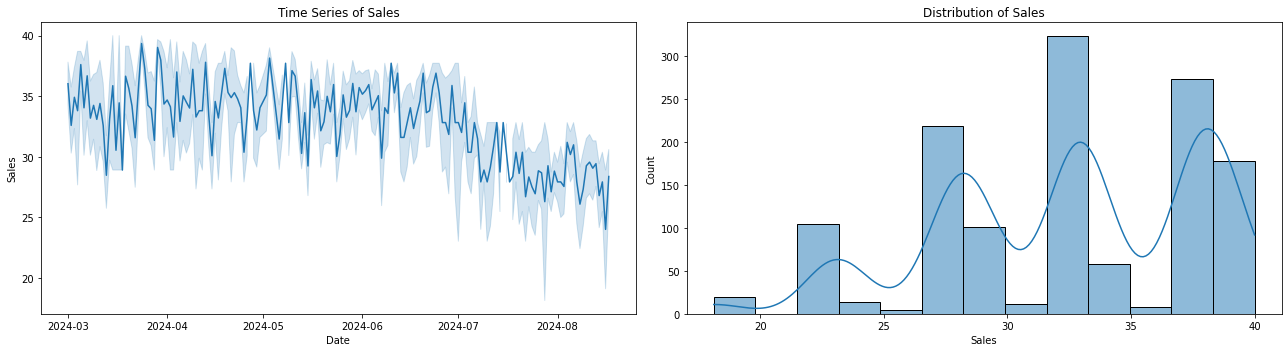

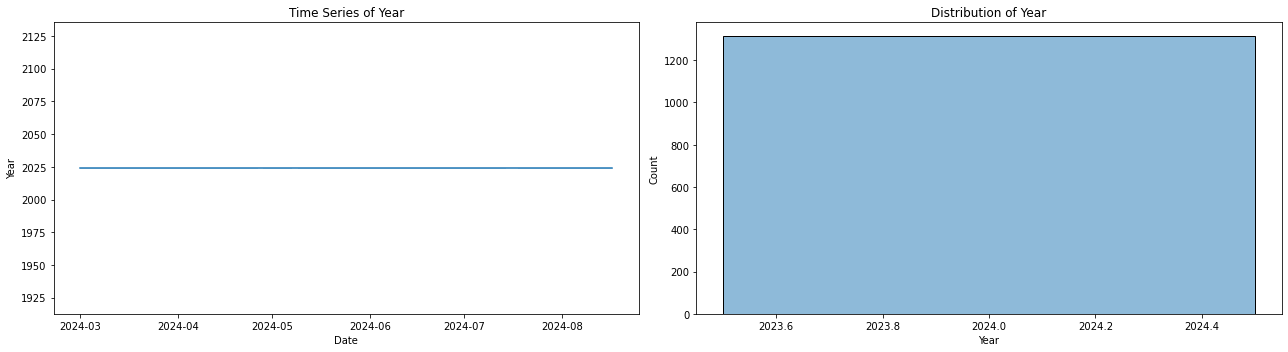

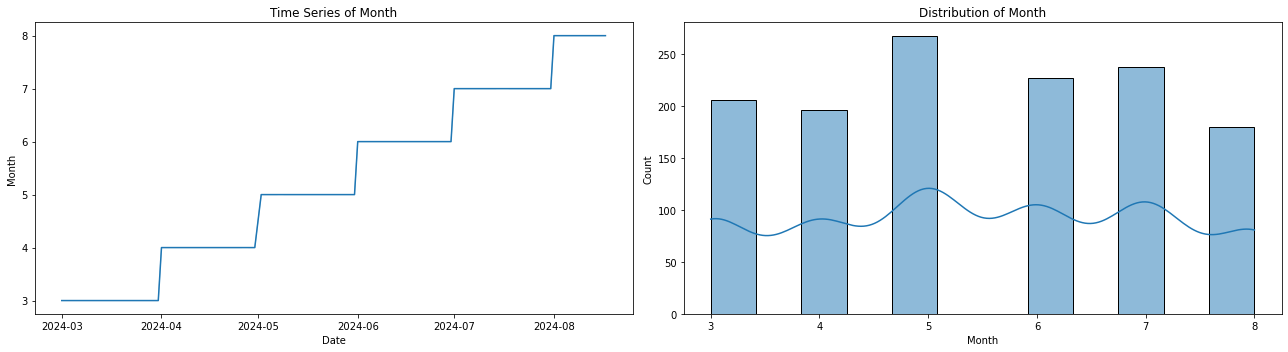

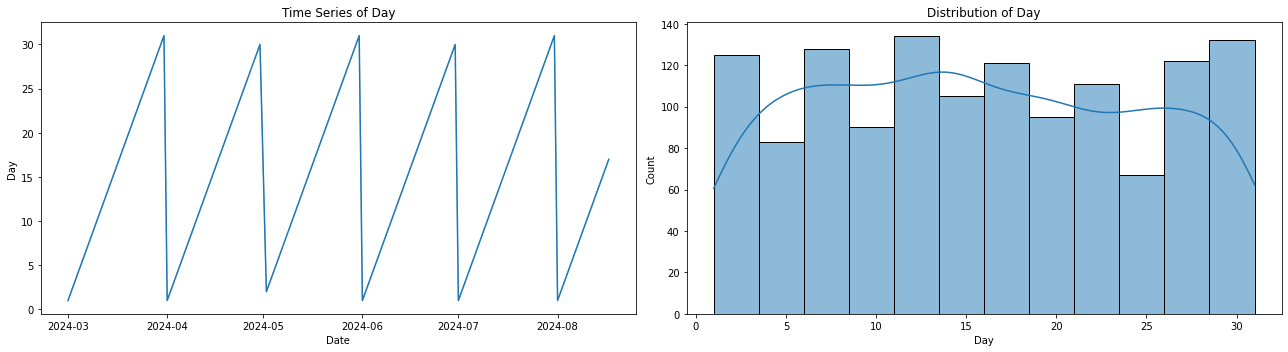

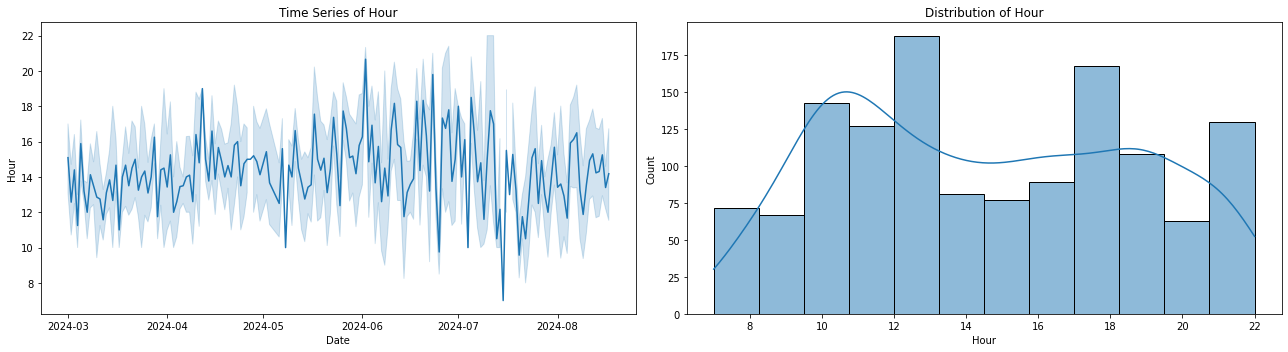

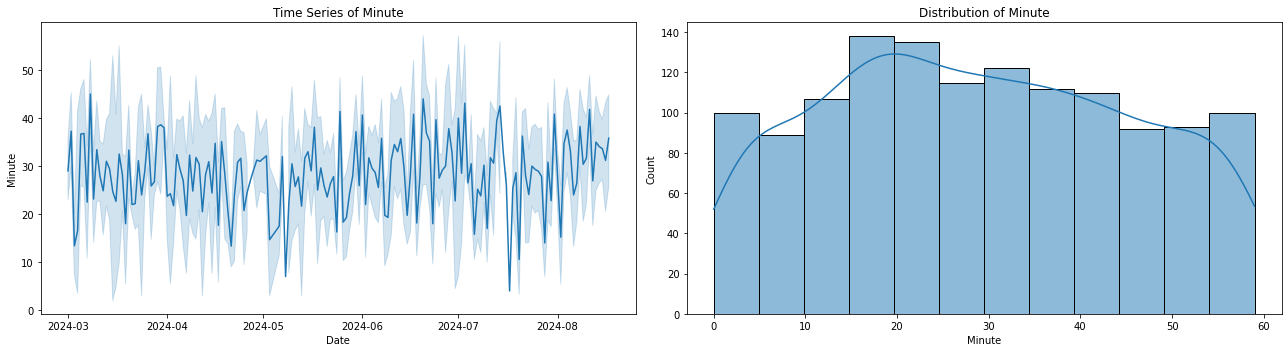

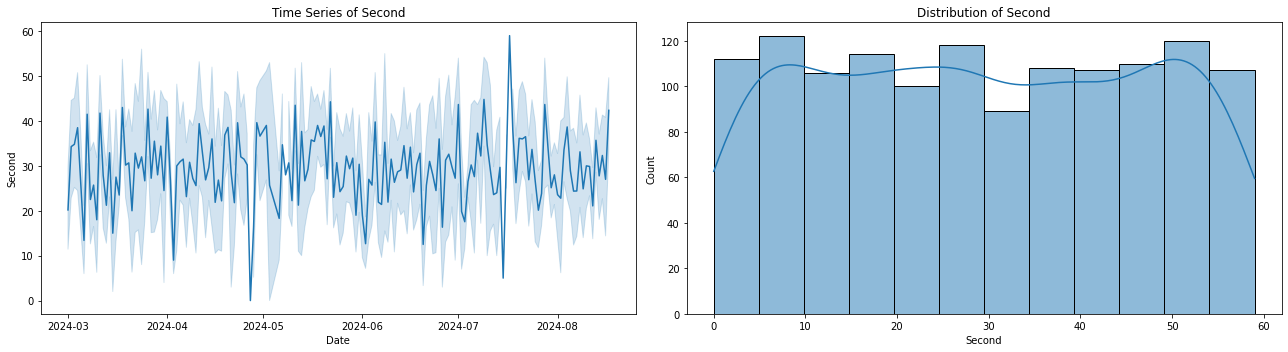

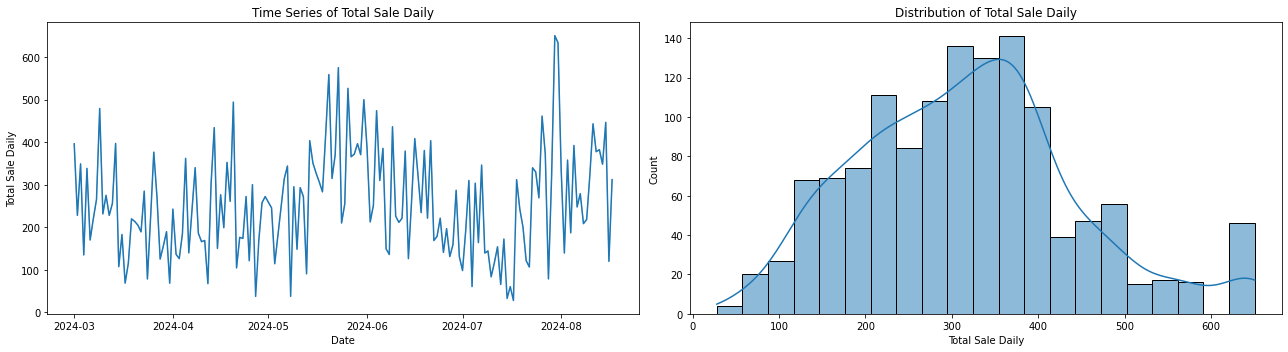

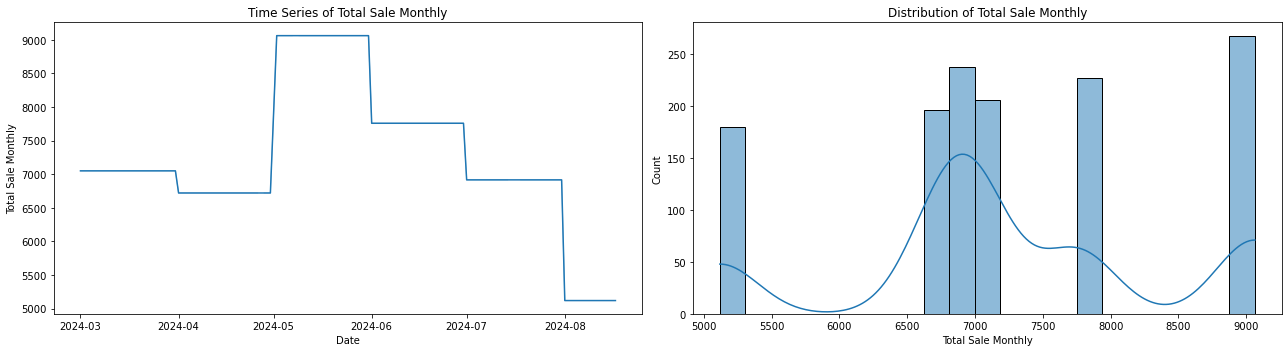

In [140]:
# Select numerical columns
numericals = df_tmp.select_dtypes(include='number').columns

for col in numericals:
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # Added one more subplot for the time series plot

    # Time series plot for trend analysis
    ax0 = sns.lineplot(
        x=pd.to_datetime(df_tmp[['year', 'month', 'day']]),  # Create a datetime object for the x-axis
        y=col,
        data=df_tmp,
        ax=axes[0]
    )
    ax0.set_title(f'Time Series of {col.replace("_", " ").title()}')
    ax0.set_xlabel('Date')
    ax0.set_ylabel(col.replace('_', ' ').title())

    # Histogram for distribution
    ax1 = sns.histplot(
        x=col,
        data=df_tmp,
        kde=True,
        ax=axes[1]
    )
    ax1.set_title(f'Distribution of {col.replace("_", " ").title()}')
    ax1.set_xlabel(col.replace('_', ' ').title())
    
    
    plt.tight_layout()
    plt.show()

In [141]:
weekday_sales=df_tmp['weekday'].value_counts()
weekday_sales

Tue    206
Thu    200
Sat    189
Wed    188
Fri    181
Mon    177
Sun    172
Name: weekday, dtype: int64

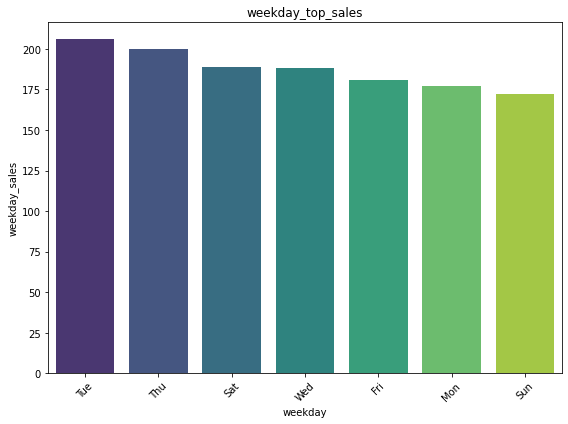

In [142]:
plt.figure(figsize=(8,6))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values, palette='viridis')


plt.xlabel('weekday')
plt.ylabel('weekday_sales')
plt.title('weekday_top_sales')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [143]:
month_sales=df_tmp['month'].value_counts()
month_sales

5    267
7    237
6    227
3    206
4    196
8    180
Name: month, dtype: int64

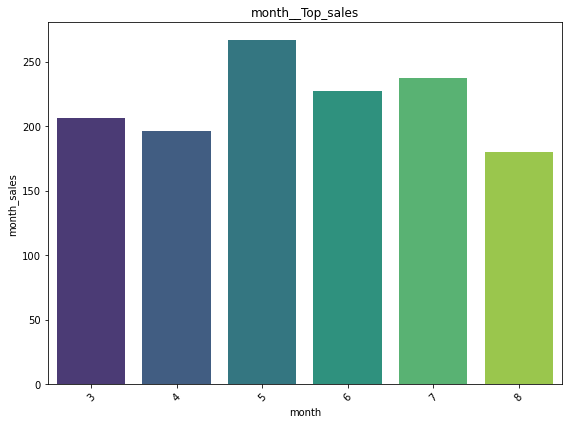

In [144]:
plt.figure(figsize=(8,6))
sns.barplot(x=month_sales.index, y=month_sales.values, palette='viridis')


plt.xlabel('month')
plt.ylabel('month_sales')
plt.title('month__Top_sales')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [145]:
coffe_distrbution = df['coffee_name'].value_counts()
coffe_distrbution

Americano with Milk    319
Latte                  282
Cappuccino             222
Americano              185
Cortado                123
Hot Chocolate           79
Espresso                59
Cocoa                   44
Name: coffee_name, dtype: int64

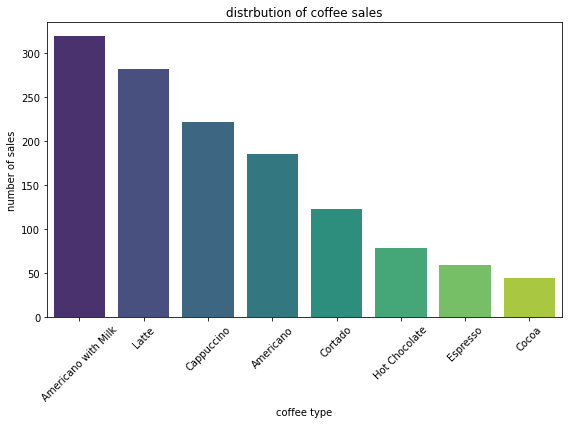

In [146]:
plt.figure(figsize=(8,6))
sns.barplot(x=coffe_distrbution.index, y=coffe_distrbution.values, palette='viridis')


plt.xlabel('coffee type')
plt.ylabel('number of sales')
plt.title('distrbution of coffee sales')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> as we can see the three top seller coffee are:
   1. americano with milk
   2. latte
   3. cappuccino
> so maybe the owner should reduce the stock of cocoa and expresso so the product
will not expire 

In [147]:
monthly_sales = df_tmp.groupby(['year', 'month', 'coffee_name'])['sales'].sum().reset_index()
monthly_sales

,year,month,coffee_name,sales
0,2024,3,Americano,1044.80
1,2024,3,Americano with Milk,1154.00
2,2024,3,Cappuccino,780.50
3,2024,3,Cocoa,232.20
4,2024,3,Cortado,869.20
5,2024,3,Espresso,241.00
6,2024,3,Hot Chocolate,854.00
7,2024,3,Latte,1874.50
8,2024,4,Americano,1001.94
9,2024,4,Americano with Milk,1407.74


In [148]:
latte_sales = monthly_sales[monthly_sales['coffee_name'] == 'Latte']
latte_sales

,year,month,coffee_name,sales
7,2024,3,Latte,1874.50
15,2024,4,Latte,1193.12
23,2024,5,Latte,2198.00
31,2024,6,Latte,1886.00
39,2024,7,Latte,1857.52
47,2024,8,Latte,1279.98


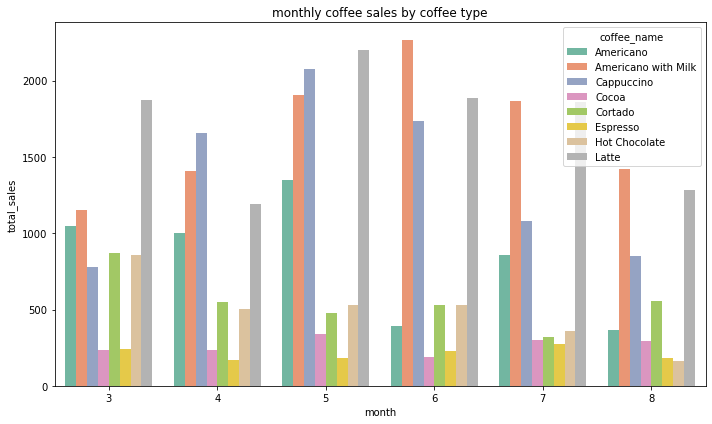

In [149]:
plt.figure(figsize=(10,6))
sns.barplot(x='month', y='sales', hue='coffee_name', data=monthly_sales, palette='Set2')

plt.xlabel('month')
plt.ylabel('total_sales')
plt.title('monthly coffee sales by coffee type')

plt.tight_layout()
plt.show()

In [150]:
df_tmp = df_tmp.drop('weekday', axis=1)
df_tmp

,cash_type,sales,coffee_name,year,month,day,hour,minute,second,total_sale_daily,total_sale_monthly
0,card,38.70,Latte,2024,3,1,10,15,50,396.30,7050.2
1,card,38.70,Hot Chocolate,2024,3,1,12,19,22,396.30,7050.2
2,card,38.70,Hot Chocolate,2024,3,1,12,20,18,396.30,7050.2
3,card,28.90,Americano,2024,3,1,13,46,33,396.30,7050.2
4,card,38.70,Latte,2024,3,1,13,48,14,396.30,7050.2
...,...,...,...,...,...,...,...,...,...,...,...
1308,card,23.02,Cortado,2024,8,17,16,31,54,312.02,5118.7
1309,card,32.82,Latte,2024,8,17,16,33,48,312.02,5118.7
1310,card,32.82,Cappuccino,2024,8,17,18,48,58,312.02,5118.7
1311,card,27.92,Americano with Milk,2024,8,17,21,18,56,312.02,5118.7


## data transforming

In [151]:
df_tmp['cash_type'] = df['cash_type'].map({'card':0, 'cash':1})
df_tmp['cash_type']

0       0
1       0
2       0
3       0
4       0
       ..
1308    0
1309    0
1310    0
1311    0
1312    0
Name: cash_type, Length: 1313, dtype: int64

In [152]:
df_tmp = pd.get_dummies(df_tmp, columns=['coffee_name'], drop_first=True)
df_tmp

,cash_type,sales,year,month,day,hour,minute,second,total_sale_daily,total_sale_monthly,coffee_name_Americano with Milk,coffee_name_Cappuccino,coffee_name_Cocoa,coffee_name_Cortado,coffee_name_Espresso,coffee_name_Hot Chocolate,coffee_name_Latte
0,0,38.70,2024,3,1,10,15,50,396.30,7050.2,0,0,0,0,0,0,1
1,0,38.70,2024,3,1,12,19,22,396.30,7050.2,0,0,0,0,0,1,0
2,0,38.70,2024,3,1,12,20,18,396.30,7050.2,0,0,0,0,0,1,0
3,0,28.90,2024,3,1,13,46,33,396.30,7050.2,0,0,0,0,0,0,0
4,0,38.70,2024,3,1,13,48,14,396.30,7050.2,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,0,23.02,2024,8,17,16,31,54,312.02,5118.7,0,0,0,1,0,0,0
1309,0,32.82,2024,8,17,16,33,48,312.02,5118.7,0,0,0,0,0,0,1
1310,0,32.82,2024,8,17,18,48,58,312.02,5118.7,0,1,0,0,0,0,0
1311,0,27.92,2024,8,17,21,18,56,312.02,5118.7,1,0,0,0,0,0,0


## machine learning model

In [154]:
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df_tmp)

In [159]:
scaled_df = pd.DataFrame(scaled_data, columns=df_tmp.columns)
scaled_df

,cash_type,sales,year,month,day,hour,minute,second,total_sale_daily,total_sale_monthly,coffee_name_Americano with Milk,coffee_name_Cappuccino,coffee_name_Cocoa,coffee_name_Cortado,coffee_name_Espresso,coffee_name_Hot Chocolate,coffee_name_Latte
0,0.0,0.940585,0.0,0.0,0.000000,0.200000,0.254237,0.847458,0.591718,0.489642,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.940585,0.0,0.0,0.000000,0.333333,0.322034,0.372881,0.591718,0.489642,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.940585,0.0,0.0,0.000000,0.333333,0.338983,0.305085,0.591718,0.489642,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.492687,0.0,0.0,0.000000,0.400000,0.779661,0.559322,0.591718,0.489642,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.940585,0.0,0.0,0.000000,0.400000,0.813559,0.237288,0.591718,0.489642,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,0.0,0.223949,0.0,1.0,0.533333,0.600000,0.525424,0.915254,0.456342,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1309,0.0,0.671846,0.0,1.0,0.533333,0.600000,0.559322,0.813559,0.456342,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1310,0.0,0.671846,0.0,1.0,0.533333,0.733333,0.813559,0.983051,0.456342,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1311,0.0,0.447898,0.0,1.0,0.533333,0.933333,0.305085,0.949153,0.456342,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
## define x and y 
X = scaled_df.drop(columns=['total_sale_daily'])
y = scaled_df['total_sale_daily']

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [162]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [164]:
y_pred = rf.predict(X_test)

In [172]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'man_squar_error: {mse}')
print(f'mean_absolute_error: {mae}')
print(f'accuracy: {r2}')

man_squar_error: 0.007611424467517751
mean_absolute_error: 0.05661343130730666
accuracy: 0.8258129008040658


In [169]:
param_grid = {
    
    'n_estimators':[100,200,300],
    'max_depth':[10,20,None],
    'min_samples_split':[2,5,10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   1.9s
[CV] END max_depth=10, min_samples_split=2, n_e

In [170]:
grid_search.best_params_

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

In [173]:
y_pred_best = best_rf.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f'Best Model Mean Squared Error: {mse_best}')
print(f'Best Model Mean Absolute Error: {mae_best}')
print(f'Best Model R² Score: {r2_best}')

Best Model Mean Squared Error: 0.007611424467517751
Best Model Mean Absolute Error: 0.05661343130730666
Best Model R² Score: 0.8258129008040658


## feature_importance 

                            feature  importance
4                               day    0.516072
3                             month    0.161341
8                total_sale_monthly    0.136449
6                            minute    0.052930
7                            second    0.046370
5                              hour    0.039321
1                             sales    0.020184
15                coffee_name_Latte    0.006009
10           coffee_name_Cappuccino    0.005310
9   coffee_name_Americano with Milk    0.004060
0                         cash_type    0.003042
12              coffee_name_Cortado    0.003009
13             coffee_name_Espresso    0.002460
14        coffee_name_Hot Chocolate    0.002450
11                coffee_name_Cocoa    0.000993
2                              year    0.000000


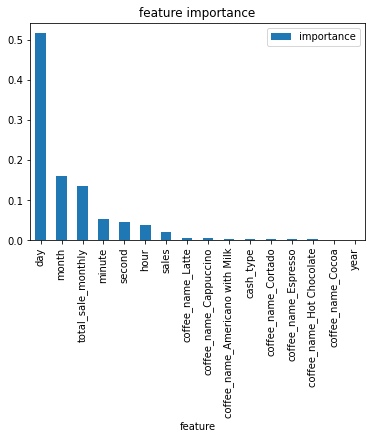

In [176]:
feature_importance = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance':feature_importance
}).sort_values(by='importance', ascending=False)


print(importance_df)

importance_df.plot(kind='bar', x='feature', y='importance', title='feature importance')
plt.show()